# Facebook Recruiting IV: Human or Bot

This notebook is a Machine Learning driven exploration of the Facebook Human vs Bot dataset from competition https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot

In [71]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

from collections import defaultdict
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Don't display scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

In [5]:
PATH = Path('./data')

In [2]:
!kaggle competitions download -c facebook-recruiting-iv-human-or-bot --path={PATH}

train.csv.zip: Downloaded 115KB of 115KB to ./data
sampleSubmission.csv: Downloaded 193KB of 193KB to ./data
test.csv.zip: Downloaded 264KB of 264KB to ./data
bids.csv.zip: Downloaded 249MB of 249MB to ./data


In [6]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}/{file}

In [6]:
train_df = pd.read_csv(PATH / 'train.csv')

In [7]:
bids = pd.read_csv(PATH / 'bids.csv')

In [8]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [9]:
train_df.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00


Let's take a sample of 200 train rows and use that to filter `bids`.

In [10]:
train_df_sample = train_df.sample(n=200)

In [11]:
sample_bids = bids[bids.bidder_id.isin(set(train_df_sample.bidder_id.values))]

## EDA

### Time series breakdown

In [12]:
bids_sorted_by_time = bids.sort_values('time')

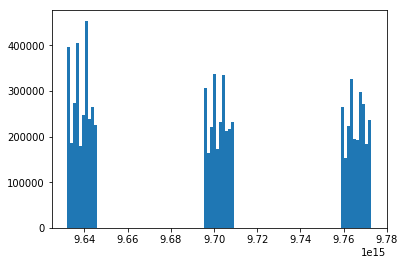

In [13]:
plt.hist(bids_sorted_by_time['time'], bins=100)
plt.show()

Looks like there are 3 distinct periods of bids.

Would be interesting to see how balanced the dataset is.

### Bids balance

In [14]:
bids_joined = bids.merge(train_df[['bidder_id', 'outcome']], left_on='bidder_id', right_on='bidder_id')

In [15]:
breakdown = bids_joined[['bid_id', 'outcome']].groupby('outcome').count()['bid_id']

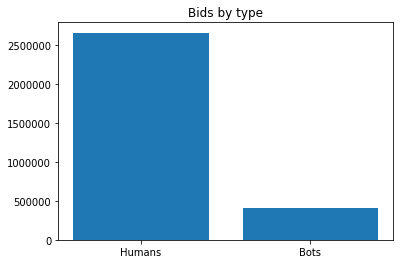

In [16]:
plt.title('Bids by type')
plt.bar(['Humans', 'Bots'], breakdown)
plt.show()

### Dataset description

In [17]:
bids.describe(include='all')

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
count,"7,656,334.00",7656334,7656334,7656334,7656334,"7,656,334.00",7647475,7656334,7656334
unique,nan,6614,15051,10,7351,nan,199,2303991,1786351
top,nan,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,jqx39,mobile,phone4,nan,in,37.95.134.218,vasstdc27m7nks3
freq,nan,515033,537347,2126587,706573,nan,1788731,61203,3499409
mean,"3,828,166.50",NaN,NaN,NaN,NaN,"9,697,977,781,760,554.00",NaN,NaN,NaN
std,"2,210,193.39",NaN,NaN,NaN,NaN,"52,505,176,512,005.31",NaN,NaN,NaN
min,0.00,NaN,NaN,NaN,NaN,"9,631,916,842,105,264.00",NaN,NaN,NaN
25%,"1,914,083.25",NaN,NaN,NaN,NaN,"9,641,138,736,842,104.00",NaN,NaN,NaN
50%,"3,828,166.50",NaN,NaN,NaN,NaN,"9,700,653,894,736,842.00",NaN,NaN,NaN
75%,"5,742,249.75",NaN,NaN,NaN,NaN,"9,761,744,315,789,472.00",NaN,NaN,NaN


## Feature eng

Firstly, some of my own features.

### Number of unique devices per bidder

In [18]:
unique_devices = bids.groupby('bidder_id')['device'].nunique().rename('NUM_UNIQUE_DEVICES')

In [19]:
unique_devices.head()

bidder_id
001068c415025a009fee375a12cff4fcnht8y    1
002d229ffb247009810828f648afc2ef593rb    2
0030a2dd87ad2733e0873062e4f83954mkj86    1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o    3
00486a11dff552c4bd7696265724ff81yeo9v    8
Name: NUM_UNIQUE_DEVICES, dtype: int64

In [20]:
train_df = train_df.join(unique_devices, on='bidder_id')

In [21]:
train_df.head()

,bidder_id,payment_account,address,outcome,NUM_UNIQUE_DEVICES
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00,14.00
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00,2.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00,2.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00,1.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00,53.00


### Number unique auctions

In [22]:
unique_auctions = bids.groupby('bidder_id')['auction'].nunique().rename('NUM_UNIQUE_AUCTIONS')

In [23]:
train_df = train_df.join(unique_auctions, on='bidder_id')

In [24]:
train_df.head()

,bidder_id,payment_account,address,outcome,NUM_UNIQUE_DEVICES,NUM_UNIQUE_AUCTIONS
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00,14.00,18.00
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00,2.00,1.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00,2.00,4.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00,1.00,1.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00,53.00,23.00


### Avg bids per auction

In [25]:
avg_bids_per_auction = bids.groupby(['bidder_id', 'auction'])['bid_id'].count().groupby('bidder_id').mean().rename('AVG_BIDS_PER_AUCTION')

In [26]:
train_df = train_df.join(avg_bids_per_auction, on='bidder_id')

In [27]:
train_df.head()

,bidder_id,payment_account,address,outcome,NUM_UNIQUE_DEVICES,NUM_UNIQUE_AUCTIONS,AVG_BIDS_PER_AUCTION
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00,14.00,18.00,1.33
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00,2.00,1.00,3.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00,2.00,4.00,1.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00,1.00,1.00,1.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00,53.00,23.00,6.74


### Avg unique countries per auction

In [28]:
avg_unique_countries_per_auction = bids.groupby(['bidder_id', 'auction'])['country'].nunique().groupby('bidder_id').mean().rename('AVG_UNIQUE_COUNTRIES_PER_AUCTION')

In [29]:
train_df = train_df.join(avg_unique_countries_per_auction, on='bidder_id')

In [30]:
train_df.head()

,bidder_id,payment_account,address,outcome,NUM_UNIQUE_DEVICES,NUM_UNIQUE_AUCTIONS,AVG_BIDS_PER_AUCTION,AVG_UNIQUE_COUNTRIES_PER_AUCTION
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00,14.00,18.00,1.33,1.17
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00,2.00,1.00,3.00,1.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00,2.00,4.00,1.00,1.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00,1.00,1.00,1.00,1.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00,53.00,23.00,6.74,1.00


### Breakdown per merchandise type

In [31]:
bids_merch_one_hot = pd.get_dummies(bids, columns=['merchandise'])

In [32]:
new_cols = [c for c in bids_merch_one_hot.columns if 'merchandise' in c]

In [33]:
bids_merch_one_hot.head()

,bid_id,bidder_id,auction,device,time,country,ip,url,merchandise_auto parts,merchandise_books and music,merchandise_clothing,merchandise_computers,merchandise_furniture,merchandise_home goods,merchandise_jewelry,merchandise_mobile,merchandise_office equipment,merchandise_sporting goods
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,0,0,0,0,0,0,1,0,0,0
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,0,0,0,0,1,0,0,0,0,0
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,0,0,0,0,0,1,0,0,0,0
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,0,0,0,0,0,0,1,0,0,0
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,0,0,0,0,0,0,1,0,0,0


In [34]:
avg_merch_per_auction_breakdown = bids_merch_one_hot[['bidder_id', 'auction'] + new_cols].groupby(['bidder_id', 'auction']).sum().groupby('bidder_id').mean()

In [35]:
avg_merch_per_auction_breakdown.columns = pd.Index([f'AVG_{c.upper()}' for c in avg_merch_per_auction_breakdown.columns])

In [36]:
avg_merch_per_auction_breakdown.head()

,AVG_MERCHANDISE_AUTO PARTS,AVG_MERCHANDISE_BOOKS AND MUSIC,AVG_MERCHANDISE_CLOTHING,AVG_MERCHANDISE_COMPUTERS,AVG_MERCHANDISE_FURNITURE,AVG_MERCHANDISE_HOME GOODS,AVG_MERCHANDISE_JEWELRY,AVG_MERCHANDISE_MOBILE,AVG_MERCHANDISE_OFFICE EQUIPMENT,AVG_MERCHANDISE_SPORTING GOODS
bidder_id,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
002d229ffb247009810828f648afc2ef593rb,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
0030a2dd87ad2733e0873062e4f83954mkj86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
00486a11dff552c4bd7696265724ff81yeo9v,0.00,0.00,0.00,0.00,0.00,1.54,0.00,0.00,0.00,0.00


In [37]:
train_df = train_df.join(avg_merch_per_auction_breakdown, on='bidder_id')

In [38]:
train_df.head()

,bidder_id,payment_account,address,outcome,NUM_UNIQUE_DEVICES,NUM_UNIQUE_AUCTIONS,AVG_BIDS_PER_AUCTION,AVG_UNIQUE_COUNTRIES_PER_AUCTION,AVG_MERCHANDISE_AUTO PARTS,AVG_MERCHANDISE_BOOKS AND MUSIC,AVG_MERCHANDISE_CLOTHING,AVG_MERCHANDISE_COMPUTERS,AVG_MERCHANDISE_FURNITURE,AVG_MERCHANDISE_HOME GOODS,AVG_MERCHANDISE_JEWELRY,AVG_MERCHANDISE_MOBILE,AVG_MERCHANDISE_OFFICE EQUIPMENT,AVG_MERCHANDISE_SPORTING GOODS
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00,14.00,18.00,1.33,1.17,0.00,0.00,0.00,0.00,0.00,1.33,0.00,0.00,0.00,0.00
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00,2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00,2.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00,53.00,23.00,6.74,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.74,0.00


The winners of the competition shared their feature engineering techniques in this article: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/discussion/14628

The second place winner said that the most useful features were:

* the median time between a user's bid and that user's previous bid
* the mean number of bids a user made per auction
* the entropy for how many bids a user placed on each day of the week
* the means of the per-auction URL entropy and IP entropy for each user
* the maximum number of bids in a 20 min span
* the total number of bids placed by the user
* the average number of bids a user placed per referring URL
* the number of bids placed by the user on each of the three weekdays in the data
* the minimum and median times between a user's bid and the previous bid by another user in the same auction.
* the fraction of IPs used by a bidder which were also used by another user which was a bot

I'll create those features initially.

### Median time between user's bids

1. Sort by bid time.
2. Diff the bid times.
3. Take the median diff per user.

In [39]:
def median_time_between_bids(df):
    bidder_ids_to_mean_diff = defaultdict(list)

    grp = df.groupby(['bidder_id', 'auction'])

    for key, df in grp:
        bidder_id, auction = key
        mean_value = df.sort_values('time')['time'].diff().mean()
        if np.isnan(mean_value):
            continue

        bidder_ids_to_mean_diff[bidder_id].append(mean_value)

    bidder_ids = []
    medians = []

    for bidder_id, diffs in bidder_ids_to_mean_diff.items():
        bidder_ids.append(bidder_id)
        medians.append(np.median(diffs))

    output = pd.DataFrame({'bidder_id': bidder_ids, 'median_between_bids': medians})
    return output.set_index('bidder_id')

In [40]:
# Test media time function.

test_dfs = pd.DataFrame({
    'bidder_id': ['abc123', 'abc123', 'abc123', 'abc123', 'abc124', 'abc124', 'abc124'],
    'time': [1000, 1002, 2000, 2002, 1000, 1005, 1006],
    'auction': ['a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a1']})
median_times = median_time_between_bids(test_dfs)
assert median_times[median_times.index == 'abc123']['median_between_bids'].values[0] == 2

In [41]:
%%time
median_df = median_time_between_bids(sample_bids)

CPU times: user 7.53 s, sys: 60.5 ms, total: 7.59 s
Wall time: 7.57 s


In [42]:
median_df.head()

,median_between_bids
bidder_id,
01255c2c7c5578c186873422fc00fd7afwk8k,"1,901,720,604,703.05"
05c9fe8f8852ea069a93dfe39fc0571er9mdt,"4,113,315,789,474.00"
08353687608279ddd83e4d36fadd1cd8ritj3,"2,474,035,087,719.33"
0870fb7e5701f3ba56762b03e157afdc1yw7u,"888,842,105,263.00"
0b450f2827ec670da34be66ec2a520213xcuk,"2,829,842,105,263.00"


In [43]:
train_df['AVG_TIME_BETWEEN_BIDS'] = train_df['bidder_id'].map(median_df['median_between_bids'])

### Entropy for how many bids a user placed on each day of the week

In [44]:
# To do

### Mean of the per-auction URL entropy and IP entropy for each user

### Maximum number of bids in a 20 minute window

* Calculate all 20 minute windows in dataset.


### Total number of bids placed by the user

In [45]:
total_bids_per_user = sample_bids.groupby(by=['bidder_id'])['bid_id'].count()

train_df['TOTAL_BIDS'] = train_df['bidder_id'].map(total_bids_per_user)
train_df['TOTAL_BIDS'] = train_df['TOTAL_BIDS'].fillna(0)

## Train

Start by training a LightGBM classifier.

In [46]:
target = train_df.pop('outcome')

In [47]:
train_df = train_df.drop(['bidder_id', 'payment_account', 'address'], axis=1)

In [48]:
train_df.head()

,NUM_UNIQUE_DEVICES,NUM_UNIQUE_AUCTIONS,AVG_BIDS_PER_AUCTION,AVG_UNIQUE_COUNTRIES_PER_AUCTION,AVG_MERCHANDISE_AUTO PARTS,AVG_MERCHANDISE_BOOKS AND MUSIC,AVG_MERCHANDISE_CLOTHING,AVG_MERCHANDISE_COMPUTERS,AVG_MERCHANDISE_FURNITURE,AVG_MERCHANDISE_HOME GOODS,AVG_MERCHANDISE_JEWELRY,AVG_MERCHANDISE_MOBILE,AVG_MERCHANDISE_OFFICE EQUIPMENT,AVG_MERCHANDISE_SPORTING GOODS,AVG_TIME_BETWEEN_BIDS,TOTAL_BIDS
0,14.00,18.00,1.33,1.17,0.00,0.00,0.00,0.00,0.00,1.33,0.00,0.00,0.00,0.00,"283,736,842,106.00",24.00
1,2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,nan,0.00
2,2.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,nan,0.00
3,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00
4,53.00,23.00,6.74,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.74,0.00,nan,0.00


In [50]:
train_X, val_X, train_y, val_y = train_test_split(train_df, target, test_size=0.2)

In [74]:
model = LGBMRegressor()

In [75]:
model.fit(train_X, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [76]:
preds = model.predict(val_X)

In [77]:
roc_auc_score(val_y, preds)

0.7448286052009456